# Compute land-atmosphere coupling indices 
This notebook takes in a series of CESM simulations, computes the land-atmosphere coupling index (CI; 
terrestrial leg only currently), and plots those seasonal means. <br>
- Note: Built to use monthly output; ideally, CI should be based on daily data. 
- Optional: Comparison against FLUXNET obs
<br><br>
Notebook created by mdfowler@ucar.edu; Last update: 11 Dec 2024 

In [1]:
import os
import glob
import numpy as np
import xarray as xr
from datetime import timedelta
import pandas as pd
import sys

# Plotting utils
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import uxarray as uxr

## 1. Modify this section for each run

In [2]:
## - - - - - - - - - - - - - - - - - - - - - -
##  Settings for case locations + names
## - - - - - - - - - - - - - - - - - - - - - -
## Where observations are stored
# obsDir   = '/glade/campaign/cgd/tss/people/mdfowler/FLUXNET2015/' ## Need to copy into CUPiD Data

## Where CESM timeseries data is stored
CESM_output_dir = os.path.join(
    os.path.sep,
    "glade",
    "campaign",
    "cesm",
    "development",
    "cross-wg",
    "diagnostic_framework",
    "CESM_output_for_testing",
)


## Full casenames that are present in CESM_output_dir and in individual filenames
# caseNames = [
#             'b.e23_alpha16b.BLT1850.ne30_t232.054',
# 'b.e30_beta02.BLT1850.ne30_t232.104',
#             ]
case_name = "b.e30_beta02.BLT1850.ne30_t232.104"

# clmFile_h = '.h0.'

start_date = "0001-01-01"
end_date = "0101-01-01"

## - - - - - - - - - - - - - - - - - - - - - -
##  Optional settings for notebook
## - - - - - - - - - - - - - - - - - - - - - -

## If comparison against FLUXNET desired
# fluxnet_comparison = True

In [3]:
# Parameters
case_name = "b.e30_beta02.BLT1850.ne30_t232.104"
base_case_name = "b.e23_alpha17f.BLT1850.ne30_t232.092"
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
start_date = "0001-01-01"
end_date = "0101-01-01"
base_start_date = "0001-01-01"
base_end_date = "0101-01-01"
lc_kwargs = {"threads_per_worker": 1}
serial = False
clmFile_h = ".h0."
fluxnet_comparison = True
obsDir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data/lnd/analysis_datasets/ungridded/timeseries/FLUXNET2015/"
subset_kwargs = {}
product = "/glade/work/samrabin/cupid_crops/examples/key_metrics/computed_notebooks//lnd/Global_TerrestrialCouplingIndex_VisualCompareObs.ipynb"


In [4]:
## - - - - - - - - - - - - - - - - - - - - - -
##  Settings for computing coupling index
## - - - - - - - - - - - - - - - - - - - - - -

# Set up directory for aux output like coupling index file
if "SCRATCH" in os.environ:
    cupid_temp = os.path.join(os.path.sep, os.environ["SCRATCH"], "CUPiD_scratch")
    os.makedirs(cupid_temp, exist_ok=True)
else:
    cupid_temp = "."

startYrs = [start_date.split("-")[0]]
endYrs = [f"{int(end_date.split('-')[0])-1:04d}"]

caseNames = [
    case_name,
    # base_case_name,
]

shortNames = [case.split(".")[-1] for case in caseNames]

## 2. Read in model data and compute terrestrial coupling index

In [5]:
"""
Inputs: xname -- controlling variable 
        yname -- responding variable
        ds    -- dataset containing xname and yname data 
        
This is pulled almost directly from Ahmed Tawfik's CI code here: 
        https://github.com/abtawfik/coupling-metrics/blob/new_version_1/src/comet/metrics/coupling_indices.py 
"""


def compute_couplingIndex_cesm(xname, yname, xDS, yDS):
    xday = xDS[xname].groupby("time.season")
    yday = yDS[yname].groupby("time.season")

    # Get the covariance of the two (numerator in coupling index)
    covarTerm = ((xday - xday.mean()) * (yday - yday.mean())).groupby(
        "time.season"
    ).sum() / xday.count()

    # Now compute the actual coupling index
    couplingIndex = covarTerm / xday.std()

    return couplingIndex

In [6]:
for iCase in range(len(caseNames)):
    ## Check first if coupling index has already been created:
    TCI_filePath = os.path.join(
        cupid_temp, f"{caseNames[iCase]}_TerrestrialCouplingIndex_SHvsSM.nc"
    )

    if os.path.exists(TCI_filePath):  # Use previously computed TCI
        print("Using previously computed coupling index saved in file ", TCI_filePath)
    else:  # Compute TCI

        # Get list of necessary time series files
        soilWater_file = np.sort(
            glob.glob(
                CESM_output_dir
                + "/"
                + caseNames[iCase]
                + "/lnd/proc/tseries/"
                + caseNames[iCase]
                + clmFile_h
                + "SOILWATER_10CM."
                + startYrs[iCase]
                + "??-"
                + endYrs[iCase]
                + "??.nc"
            )
        )
        if len(soilWater_file) == 0:
            print("Soil moisture file not found!")
        elif len(soilWater_file) > 1:
            print(
                "More than one file matches requested time period and case for soil moisture."
            )
        elif len(soilWater_file) == 1:
            soilWater_DS = xr.open_dataset(soilWater_file[0], decode_times=True)

        sh_file = np.sort(
            glob.glob(
                CESM_output_dir
                + "/"
                + caseNames[iCase]
                + "/lnd/proc/tseries/"
                + caseNames[iCase]
                + clmFile_h
                + "FSH_TO_COUPLER."
                + startYrs[iCase]
                + "??-"
                + endYrs[iCase]
                + "??.nc"
            )
        )
        if len(sh_file) == 0:
            print("Land-based SHFLX file not found!")
        elif len(sh_file) > 1:
            print("More than one file matches requested time period and case for SH.")
        elif len(sh_file) == 1:
            shflx_DS = xr.open_dataset(sh_file[0])

        # If years start at 0000, offset by 1700 years for analysis
        yrOffset = 1850
        if shflx_DS["time.year"].values[0] < 1500:
            shflx_DS["time"] = shflx_DS.time + timedelta(days=yrOffset * 365)
        if soilWater_DS["time.year"].values[0] < 1500:
            soilWater_DS["time"] = soilWater_DS.time + timedelta(days=yrOffset * 365)
        # Convert times to datetime for easier use
        shflx_DS["time"] = shflx_DS.indexes["time"].to_datetimeindex()
        soilWater_DS["time"] = soilWater_DS.indexes["time"].to_datetimeindex()

        # Add case ID (short name) to the DS
        shflx_DS = shflx_DS.assign_coords({"case": shortNames[iCase]})
        soilWater_DS = soilWater_DS.assign_coords({"case": shortNames[iCase]})

        ## Compute coupling index and save to netCDF file
        ## - - - - - - - - - - - - - - - - - - - - - - - - -
        xname = "SOILWATER_10CM"  # Controlling variable
        yname = "FSH_TO_COUPLER"  # Responding variable

        xDS = soilWater_DS
        yDS = shflx_DS

        couplingInd = compute_couplingIndex_cesm(xname, yname, xDS, yDS)
        couplingInd.to_netcdf(TCI_filePath)
        print("File created: ", TCI_filePath)

Using previously computed coupling index saved in file  /glade/derecho/scratch/samrabin/CUPiD_scratch/b.e30_beta02.BLT1850.ne30_t232.104_TerrestrialCouplingIndex_SHvsSM.nc


### 2.1 Read in FLUXNET data if requested

In [7]:
# --------------------------------------------------------
# Function to read requested variables from FLUXNET file.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#
# Inputs:  fileName --> Full path to FLUXNET data file
#          varNames --> An array of variable names to be
#                       retrieved from said data file.
#                       NOTE: If you wish to retrieve *all*
#                       variables, pass the string 'ALL'.
#
# Outputs: fluxnetID --> ID string used to identify station
#          fluxnetDS --> An x-array dataset containing the
#                        requested variables.
#                        Missing values will be set to NaN.
#
# --------------------------------------------------------


def readFLUXNET_var(fileName, varNames):
    # Get ID of station
    startID = fileName.find("FLX_")
    fluxnetID = fileName[startID + 4 : startID + 10]

    # If this is taking a long time or you just want to know where in the stations you are, uncomment print statement
    # print('Reading in site - ', fluxnetID)

    # Read in CSV file containing data
    dataDF = pd.read_csv(fileName)

    # Return ALL variables from dataDF if requested
    if varNames == "ALL":
        fluxnetDF = dataDF

        # Set any value that's missing to NaN (not -9999)
        fluxnetDF = fluxnetDF.replace(-9999, np.nan)

        # If time has been requested, reformat to pandas date index
        fluxnetDF["TIMESTAMP"] = pd.to_datetime(
            fluxnetDF["TIMESTAMP"].values, format="%Y%m%d"
        )
        fluxnetDF = fluxnetDF.set_index(["TIMESTAMP"])

        # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
        #   NOTE: since current implementation doesn't use the pre-formatted CoMeT, might not need this step now
        fluxnetDS = fluxnetDF.to_xarray()

    # Reduce returned DF to contain only variables of interest
    else:

        # Check that requested variables are available in specific file
        errCount = 0  # Initialize flag for error
        colNames = dataDF.columns.values  # Available variables in file

        for iVar in range(len(varNames)):  # Check each variable individually
            if (varNames[iVar] in colNames) == False:
                # Turn on print statement for more verbose output
                # print('** ERROR: %13s   not contained in file for %8s  **' %(varNames[iVar], fluxnetID))

                # If any variable is not conatined in file, return a NaN
                fluxnetDS = -999
                errCount = errCount + 1

        # If all the variables *are* available, isolate those in DF and return that
        if errCount == 0:
            fluxnetDF = dataDF[varNames]

            # Set any value that's missing to NaN (not -999)
            fluxnetDF = fluxnetDF.replace(-9999, np.nan)

            # If time has been requested, reformat to pandas make index
            if ("TIMESTAMP" in varNames) == True:
                fluxnetDF["TIMESTAMP"] = pd.to_datetime(
                    fluxnetDF["TIMESTAMP"].values, format="%Y%m%d"
                )
                fluxnetDF = fluxnetDF.set_index(["TIMESTAMP"])

            # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
            fluxnetDS = fluxnetDF.to_xarray()

    return (fluxnetID, fluxnetDS)


"""
Inputs: xname -- controlling variable 
        yname -- responding variable
        ds    -- dataset containing xname and yname data 
        
This is pulled almost directly from Ahmed Tawfik's CI code here: 
        https://github.com/abtawfik/coupling-metrics/blob/new_version_1/src/comet/metrics/coupling_indices.py 
"""


def compute_couplingIndex_FLUXNET(xname, yname, ds):
    xday = ds[xname].groupby("TIMESTAMP.season")
    yday = ds[yname].groupby("TIMESTAMP.season")

    # Get the covariance of the two (numerator in coupling index)
    covarTerm = ((xday - xday.mean()) * (yday - yday.mean())).groupby(
        "TIMESTAMP.season"
    ).sum() / xday.count()

    # Now compute the actual coupling index
    couplingIndex = covarTerm / xday.std()

    return couplingIndex

In [8]:
if fluxnet_comparison == True:
    # obsDir   = '/glade/campaign/cgd/tss/people/mdfowler/FLUXNET2015/' ## Need to copy into CUPiD Data

    ## Metadata files
    siteInfoFile = obsDir + "SiteList.csv"
    siteInfoDF = pd.read_csv(siteInfoFile)

    metadataFile = obsDir + "FLX_AA-Flx_BIF_ALL_20200501/FLX_AA-Flx_BIF_DD_20200501.csv"
    metadataDF = pd.read_csv(metadataFile)

    ## List of all station files
    dataFiles = glob.glob(obsDir + "FLX_*/*SUBSET_DD*")

    # Set up a few empty arrays to save data into
    terraCI_fluxnetConverted = np.full(
        [len(dataFiles), 4], np.nan
    )  # CI using kg/m2 soil water content  [nStations, seasons]

    # Also save out some data on each station
    startTime_fluxnet = np.zeros(len(dataFiles), dtype="datetime64[s]")
    endTime_fluxnet = np.zeros(len(dataFiles), dtype="datetime64[s]")
    lat_fluxnet = np.full([len(dataFiles)], np.nan)
    lon_fluxnet = np.full([len(dataFiles)], np.nan)
    SWCdepth = np.full([len(dataFiles)], np.nan)

    stationID = []
    stationID_converted = []

    allStationID = []

    # Variables I want returned:
    varNames = ["TIMESTAMP", "H_F_MDS", "SWC_F_MDS_1", "SWC_F_MDS_1_QC"]

    # Loop over each station (data file)
    for iStation in range(len(dataFiles)):

        # Read in data
        # ----------------------------------------------------------
        fluxnetID, fluxnetDS = readFLUXNET_var(dataFiles[iStation], varNames)

        # Save lat and lon for this station
        # ----------------------------------------------------------
        indStation = int(np.where(fluxnetID == siteInfoDF["SITE_ID"])[0][0])
        lat_fluxnet[iStation] = siteInfoDF["LOCATION_LAT"].values[indStation]
        lon_fluxnet[iStation] = siteInfoDF["LOCATION_LONG"].values[indStation]
        allStationID.append(fluxnetID)

        # Check that there was data saved for this particular site:
        # ----------------------------------------------------------
        if type(fluxnetDS) == int:
            print("No data for station: %8s" % fluxnetID)

        elif (np.all(np.isnan(fluxnetDS["H_F_MDS"])) == True) | (
            np.all(np.isnan(fluxnetDS["SWC_F_MDS_1"])) == True
        ):
            print("No data for station: %8s" % fluxnetID)

        # If data is present:
        # ----------------------------------------------------------
        else:
            # Only consider where data is actually present for selected vars
            iReal = np.where(
                (np.isfinite(fluxnetDS["SWC_F_MDS_1"]) == True)
                & (np.isfinite(fluxnetDS["H_F_MDS"]) == True)
            )[0]
            fluxnetDS = fluxnetDS.isel(TIMESTAMP=iReal)

            stationID.append(fluxnetID)

            # Convert units from volumetric (%) to mass (kg/m2)
            # -------------------------------------------------
            #   Step 1: Convert from % to fraction
            fracSM = (fluxnetDS["SWC_F_MDS_1"].values) / 100.0

            #    Step 2: Need to use depth of obs in conversion
            metaData_station = metadataDF[metadataDF.SITE_ID == fluxnetID]
            iSWC = np.where(metaData_station.DATAVALUE == "SWC_F_MDS_1")[0]
            #  Some locations (5) have two depths
            if len(iSWC) > 1:
                for iDepth in range(len(iSWC)):
                    SWC_DF = metaData_station[iSWC[iDepth] : iSWC[iDepth] + 4]

                    depth = np.asarray(
                        SWC_DF[SWC_DF.VARIABLE == "VAR_INFO_HEIGHT"].DATAVALUE.values[0]
                    ).astype(float)
                    depthDay = np.asarray(
                        SWC_DF[SWC_DF.VARIABLE == "VAR_INFO_DATE"].DATAVALUE.values[0]
                    ).astype(int)
                    depthDay = int(
                        str(depthDay)[:8]
                    )  # Some weird ones have time attached; don't want that
                    depthDay = pd.to_datetime(depthDay, format="%Y%m%d")

                    # Keep deepest level as the depth for station
                    if iDepth == 0:
                        SWCdepth[iStation] = depth
                        convertSM = fracSM * 1000.0 * np.abs(depth)
                    else:
                        # Use date as break point for getting kg/m2 SWC
                        #  Eq: SWC_kgm2 = SWC_vol [m3/m3] * 1000 [kg/m3] * depth [m]
                        dateArr = pd.DatetimeIndex(fluxnetDS.TIMESTAMP.values)
                        iTime = int(np.where(dateArr == depthDay)[0][0])
                        convertSM[iTime::] = (fracSM[iTime::]) * 1000.0 * np.abs(depth)

                        # Keep deepest level as the depth for station
                        if depth < SWCdepth[iStation]:
                            SWCdepth[iStation] = depth

                stationID_converted.append(fluxnetID)

            # If station only has one level recorded, things are a bit easier:
            else:
                SWC_DF = metaData_station[iSWC[0] : iSWC[0] + 4]
                SWCdepth[iStation] = np.asarray(
                    SWC_DF[SWC_DF.VARIABLE == "VAR_INFO_HEIGHT"].DATAVALUE.values[0]
                ).astype(float)
                convertSM = fracSM * 1000.0 * np.abs(SWCdepth[iStation])

                stationID_converted.append(fluxnetID)

            # Save converted soil moisture to dataset
            fluxnetDS["SWC_F_MDS_1_convert"] = (("TIMESTAMP"), convertSM)

            # Save first and last time used for computing CI
            # ----------------------------------------------
            startTime_fluxnet[iStation] = fluxnetDS["TIMESTAMP"].values[0]
            endTime_fluxnet[iStation] = fluxnetDS["TIMESTAMP"].values[-1]

            # Compute terrestrial coupling metric
            # -----------------------------------
            terraLeg = compute_couplingIndex_FLUXNET(
                "SWC_F_MDS_1_convert", "H_F_MDS", fluxnetDS
            )

            # If there's less than one full year of data, don't use station
            #   (i.e., as long as all 4 seasons are defined, save values)
            if np.shape(terraLeg)[0] == 4:
                terraCI_fluxnetConverted[iStation, :] = terraLeg

    seasons = terraLeg.season

    ## Print some useful information
    print(
        "Number of FLUXNET stations with CI calculated: %i"
        % len(np.where(np.isfinite(terraCI_fluxnetConverted[:, 1]) == True)[0])
    )

    # How many months go into each calculation of CI for JJA?
    nMonths = np.full([len(dataFiles)], np.nan)

    for iSt in range(len(dataFiles)):
        if np.isfinite(terraCI_fluxnetConverted[iSt, 1]):
            dateRange = pd.date_range(
                start=startTime_fluxnet[iSt], end=endTime_fluxnet[iSt], freq="ME"
            )
            nMonths[iSt] = len(
                np.where((dateRange.month >= 6) & (dateRange.month <= 8))[0]
            )

    print(
        "Minimum number of months used for JJA mean CI: %i " % int(np.nanmin(nMonths))
    )
    print(
        "Maximum number of months used for JJA mean CI: %i " % int(np.nanmax(nMonths))
    )

No data for station:   US-Prr
No data for station:   US-Tw4


No data for station:   AU-Cum


No data for station:   ES-Ln2


No data for station:   US-Ha1


No data for station:   BR-Sa1
No data for station:   FI-Lom


No data for station:   US-Cop


No data for station:   US-Atq
No data for station:   US-Wi4


No data for station:   CZ-wet


No data for station:   GL-NuF


No data for station:   US-GBT
No data for station:   US-Wi5


No data for station:   US-Los
No data for station:   DE-Akm


No data for station:   NL-Hor
No data for station:   US-Wi6
No data for station:   BE-Bra


No data for station:   US-Ivo


No data for station:   DE-SfN


No data for station:   AR-Vir
No data for station:   US-ORv


No data for station:   US-Wi3
No data for station:   CA-Obs


No data for station:   US-Wi2
No data for station:   US-Wi9


No data for station:   DE-Spw
No data for station:   FR-Pue


No data for station:   US-Ne3
No data for station:   DE-RuS


No data for station:   DE-Zrk
No data for station:   CA-Man
No data for station:   US-Twt


No data for station:   US-Wi7


No data for station:   IT-La2
No data for station:   US-Wi1


No data for station:   US-Wi8


No data for station:   GL-ZaF
No data for station:   US-Myb


No data for station:   US-WPT


No data for station:   DE-RuR


No data for station:   FR-Fon
No data for station:   US-Ne2


No data for station:   CG-Tch


No data for station:   RU-Che
No data for station:   US-Tw1


No data for station:   RU-Cok


No data for station:   US-Wi0


No data for station:   FI-Let


No data for station:   SJ-Adv
Number of FLUXNET stations with CI calculated: 150
Minimum number of months used for JJA mean CI: 1 
Maximum number of months used for JJA mean CI: 57 


*Make some choices on limiting which stations are used*
- Let's limit usage to depths less than 20 cm (arbitrary, but I don't want us using non-surface soil moisture for this application). This will eliminate 11 stations.
- It would also be good to put some time limits on this. So let's say the observations need to have at least 9 months of data for JJA means (3-years). Otherwise, set terraCI to np.nan again so we don't use it.

In [9]:
if fluxnet_comparison == True:

    # Get stations with SWC from below 20 cm (or equal to zero)
    iLimit = np.where((SWCdepth == 0.0) | (SWCdepth < -0.2))[0]

    # Set the terrestrial leg of CI to missing so we don't consider those
    terraCI_fluxnetConverted[iLimit, :] = np.nan

    print(
        "Number of FLUXNET stations to use with reasonable depths of SWC: %i"
        % len(np.where(np.isfinite(terraCI_fluxnetConverted[:, 1]) == True)[0])
    )

    # Get stations with less than 9 months used for JJA terrestrial CI
    iLimit = np.where(nMonths < 9)[0]

    # Set to missing so we don't consider stations with less than three years of data going into the average
    terraCI_fluxnetConverted[iLimit, :] = np.nan

    print(
        "Number of FLUXNET stations to use with 3+ years of JJA data: %i"
        % len(np.where(np.isfinite(terraCI_fluxnetConverted[:, 1]) == True)[0])
    )

Number of FLUXNET stations to use with reasonable depths of SWC: 139
Number of FLUXNET stations to use with 3+ years of JJA data: 115


## 3. Make plots

In [10]:
## Load coupling index with uxarray
gridFile = (
    "/glade/p/cesmdata/cseg/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc"
)
uxgrid = uxr.open_grid(gridFile)
uxgrid

<uxarray.Grid>
Original Grid Type: ESMF
Grid Dimensions:
  * n_node: 48602
  * n_face: 48600
  * n_max_face_nodes: 4
  * n_nodes_per_face: (48600,)
Grid Coordinates (Spherical):
  * node_lon: (48602,)
  * node_lat: (48602,)
  * face_lon: (48600,)
  * face_lat: (48600,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (48600, 4)
Grid Descriptor Variables:
  * n_nodes_per_face: (48600,)

In [11]:
for iCase in range(len(caseNames)):
    TCI_filePath = os.path.join(
        cupid_temp, f"{caseNames[iCase]}_TerrestrialCouplingIndex_SHvsSM.nc"
    )

    couplingIndex_case = uxr.open_dataset(gridFile, TCI_filePath)
    # Rename the variable:
    couplingIndex_case = couplingIndex_case.rename(
        {"__xarray_dataarray_variable__": "CouplingIndex"}
    )

    # Assign case coord
    couplingIndex_case = couplingIndex_case.assign_coords(
        {"case": couplingIndex_case.case.values}
    )

    # Return all the cases in a single dataset
    if iCase == 0:
        couplingIndex_DS = couplingIndex_case
        del couplingIndex_case
    else:
        couplingIndex_DS = uxr.concat([couplingIndex_DS, couplingIndex_case], "case")
        del couplingIndex_case

print("Coupling index is now ready to go")

Coupling index is now ready to go


In [12]:
def make_cmap(colors, position=None, bit=False):
    """
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    """

    import matplotlib as mpl
    import numpy as np

    bit_rgb = np.linspace(0, 1, 256)
    if position == None:
        position = np.linspace(0, 1, len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")

    if bit:
        for i in range(len(colors)):
            colors[i] = (
                bit_rgb[colors[i][0]],
                bit_rgb[colors[i][1]],
                bit_rgb[colors[i][2]],
            )

    cdict = {"red": [], "green": [], "blue": []}
    for pos, color in zip(position, colors):
        cdict["red"].append((pos, color[0], color[0]))
        cdict["green"].append((pos, color[1], color[1]))
        cdict["blue"].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap("my_colormap", cdict, 256)
    return cmap

In [13]:
### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [
    (124, 135, 181),
    (107, 109, 161),
    (51, 82, 120),
    (49, 114, 127),
    (97, 181, 89),
    (200, 218, 102),
    (255, 242, 116),
    (238, 164, 58),
]  # This example uses the 8-bit RGB
my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)

In [14]:
def plotTCI_case(seasonstr, caseSel=None):

    transform = ccrs.PlateCarree()
    projection = ccrs.PlateCarree()

    if caseSel:
        # create a Poly Array from a 1D slice of a face-centered data variable
        collection = (
            couplingIndex_DS["CouplingIndex"]
            .sel(season=seasonstr)
            .isel(case=caseSel)
            .to_polycollection()
        )

        collection.set_transform(transform)
        collection.set_antialiased(False)
        collection.set_cmap(my_cmap_SMvSHF)
        collection.set_clim(vmin=-20, vmax=5)

        fig, ax = plt.subplots(
            1,
            1,
            figsize=(12, 5),
            facecolor="w",
            constrained_layout=True,
            subplot_kw=dict(projection=projection),
        )

        ax.coastlines()
        ax.add_collection(collection)
        ax.set_global()
        fig.colorbar(collection, label="Terrestrial Coupling Index ($W m^{-2}$)")
        ax.set_title(
            seasonstr
            + " Coupling Index: "
            + str(couplingIndex_DS.case.isel(case=caseSel).values)
        )

        plt.show()
        plt.close()

    else:
        # create a Poly Array from a 1D slice of a face-centered data variable
        collection = (
            couplingIndex_DS["CouplingIndex"].sel(season=seasonstr).to_polycollection()
        )

        collection.set_transform(transform)
        collection.set_antialiased(False)
        collection.set_cmap(my_cmap_SMvSHF)
        collection.set_clim(vmin=-20, vmax=5)

        fig, ax = plt.subplots(
            1,
            1,
            figsize=(12, 5),
            facecolor="w",
            constrained_layout=True,
            subplot_kw=dict(projection=projection),
        )

        ax.coastlines()
        ax.add_collection(collection)
        ax.set_global()
        fig.colorbar(collection, label="Terrestrial Coupling Index ($W m^{-2}$)")
        ax.set_title(
            seasonstr + " Coupling Index: " + str(couplingIndex_DS.case.values)
        )

        if fluxnet_comparison == True:
            ## Add FLUXNET obs
            iSeason = np.where(seasons == seasonstr)[0]
            iStations = np.where(
                np.isfinite(terraCI_fluxnetConverted[:, iSeason]) == True
            )[0]
            norm_CI = matplotlib.colors.Normalize(vmin=-20, vmax=5)

            ax.scatter(
                lon_fluxnet[iStations],
                lat_fluxnet[iStations],
                c=terraCI_fluxnetConverted[iStations, iSeason],
                cmap=my_cmap_SMvSHF,
                norm=norm_CI,
                edgecolor="k",
                s=30,
                marker="o",
                transform=ccrs.PlateCarree(),
            )

        plt.show()
        plt.close()

    return

In [15]:
def plotScatter(seasonstr, caseSel=None):
    node_lats = uxgrid.face_lat.values
    node_lons = uxgrid.face_lon.values

    predictions = []

    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    CI_model = couplingIndex_DS["CouplingIndex"].sel(season=seasonstr)

    iSeason = np.where(seasons == seasonstr)[0]
    iStations = np.where(np.isfinite(terraCI_fluxnetConverted[:, iSeason]) == True)[0]

    for iPoint in range(len(iStations)):
        this_lon = lon_fluxnet[iStations[iPoint]]  # lon1
        this_lat = lat_fluxnet[iStations[iPoint]]  # lat1
        obs_point = np.array((this_lon, this_lat))

        # Get subset of relevant points
        i = np.where(
            (node_lats >= (this_lat - 2))
            & (node_lats <= (this_lat + 2))
            & (node_lons >= (this_lon - 2))
            & (node_lons <= (this_lon + 2))
        )[0]

        minDistance = 100
        for iSelClose in range(len(i)):
            # Find point in uxarray? Use euclidian distance
            distance = np.linalg.norm(
                obs_point - np.array((node_lons[i[iSelClose]], node_lats[i[iSelClose]]))
            )

            if (distance < minDistance) & (
                np.isfinite(
                    couplingIndex_DS["CouplingIndex"]
                    .sel(season="JJA")
                    .values[i[iSelClose]]
                )
                == True
            ):
                minDistance = distance
                selLon = node_lons[i[iSelClose]]
                selLat = node_lats[i[iSelClose]]
                selLoc = i[iSelClose]

        predictions = np.append(
            predictions,
            couplingIndex_DS["CouplingIndex"].sel(season=seasonstr).values[selLoc],
        )
        axs.plot(
            terraCI_fluxnetConverted[iPoint, iSeason],
            couplingIndex_DS["CouplingIndex"].sel(season=seasonstr).values[selLoc],
            "bo",
            alpha=0.5,
        )

    axs.set_xlabel("FLUXNET CI Value", fontsize=12)
    axs.set_ylabel("CESM CI Value", fontsize=12)
    axs.set_title(
        "Individual station CI vs. nearest gridcell CI: " + seasonstr, fontsize=14
    )
    axs.set_xlim([-25, 25])
    axs.set_ylim([-25, 25])
    axs.plot(np.arange(-25, 26), np.arange(-25, 26), "k--")

    rmse = np.sqrt(
        ((predictions - terraCI_fluxnetConverted[iStations, iSeason]) ** 2).mean()
    )
    axs.text(0.05, 0.95, "RMSE: " + str(rmse), transform=axs.transAxes)

    return axs

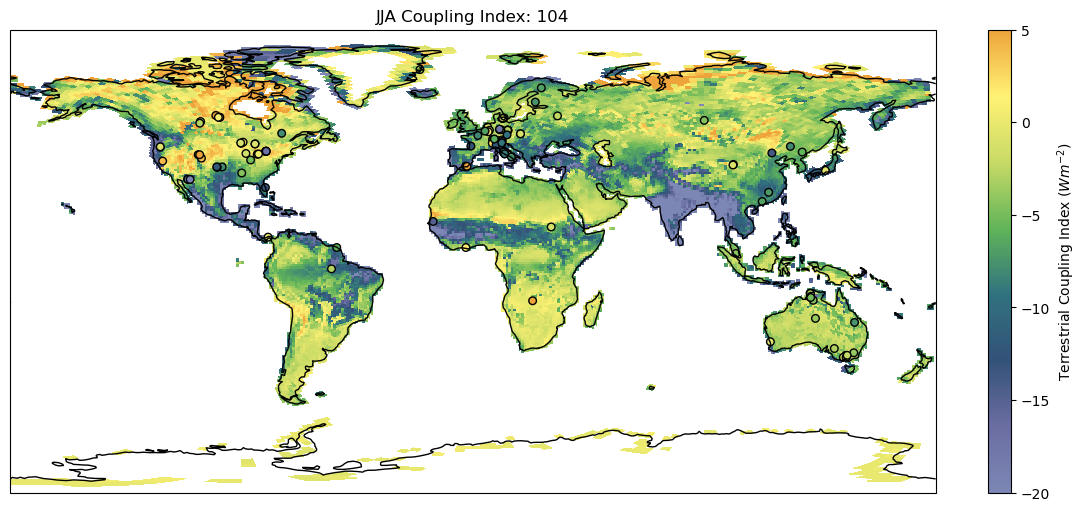

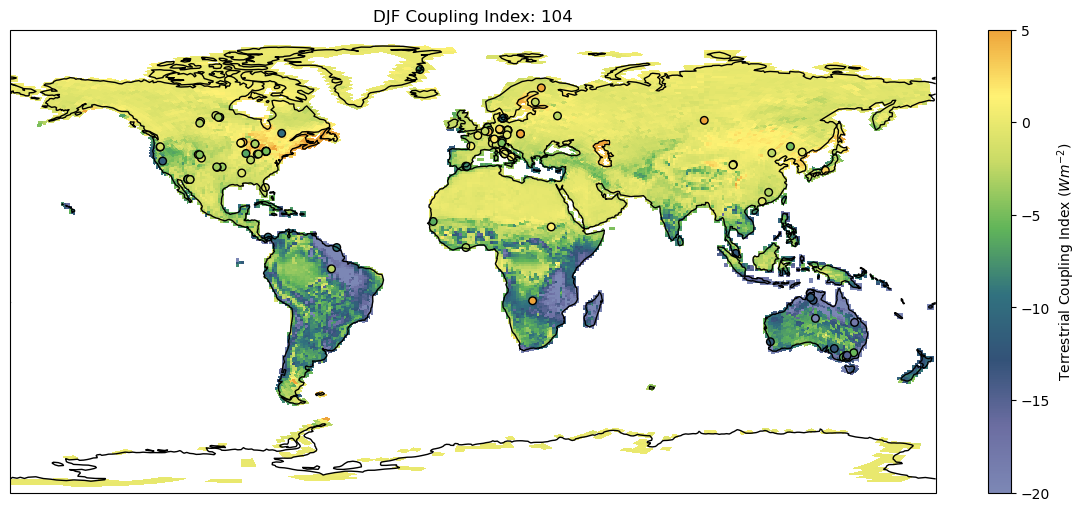

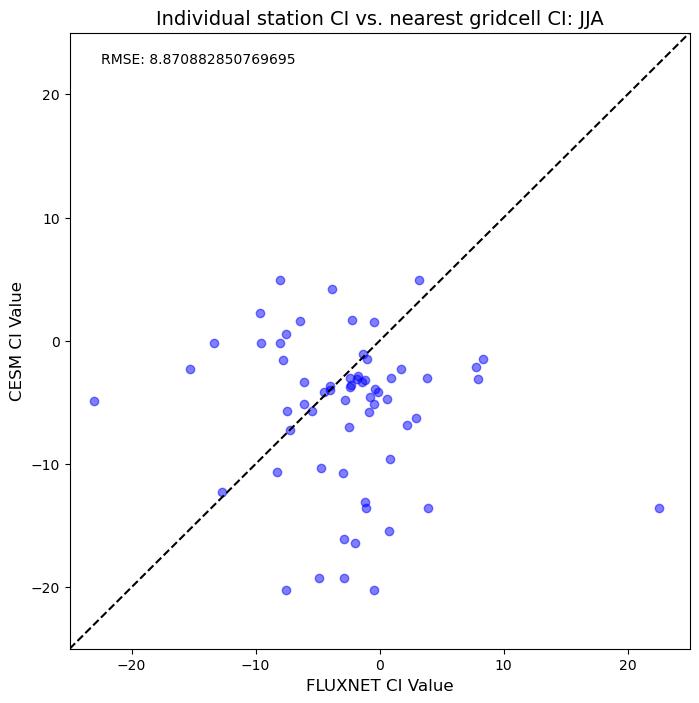

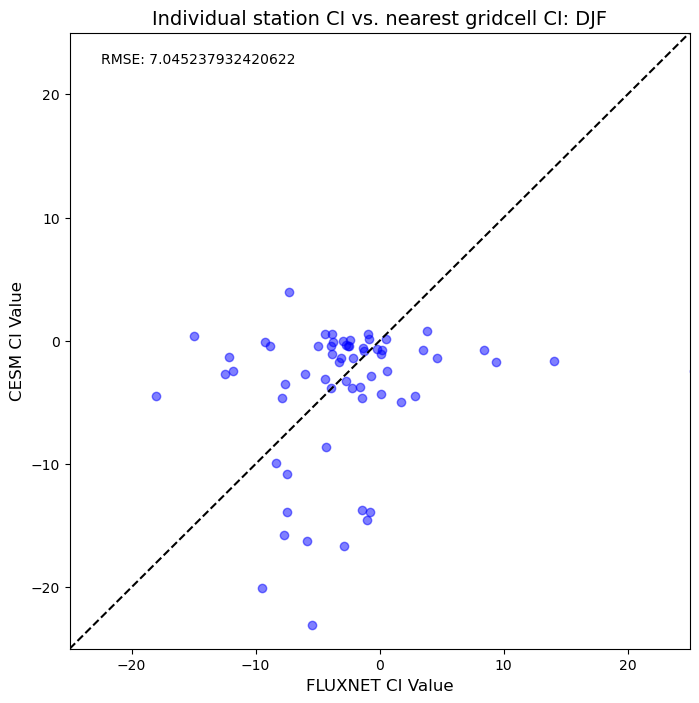

In [16]:
if len(caseNames) == 1:
    plotTCI_case("JJA", None)
    plotTCI_case("DJF", None)

    plotScatter("JJA", None)
    plotScatter("DJF", None)
else:
    for iCase in range(len(caseNames)):
        plotTCI_case("JJA", iCase)
        plotTCI_case("DJF", iCase)

        plotScatter("JJA", iCase)
        plotScatter("DJF", iCase)